In [209]:
import numpy as np
import pandas as pd
import os
import math
import sys
import matplotlib.pyplot as plt
import tarfile
from tqdm import tqdm
import sqlite3 as sql
import pyarrow as pa
import pyarrow.parquet as pq
# 1 min 15 sec

In [210]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [211]:
# Now import from Enum
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [212]:
source_root = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/"

In [213]:
def convertParquetToDF(file:str) -> pd.DataFrame:
    table = pq.read_table(file)
    df = table.to_pandas()
    return df

In [214]:
def convertDBtoDF(file: str, table: str, N_events: int = None) -> pd.DataFrame:
    con = sql.connect(file)
    # First, get the distinct event_no values, limited by N_events
    print(f"Reading {N_events} events from {table} of {file}")
    event_no_query = f"SELECT DISTINCT event_no FROM {table} LIMIT {N_events}"
    event_nos = pd.read_sql_query(event_no_query, con)["event_no"].tolist()

    # Construct the main query to filter by the selected event_nos
    event_no_list = ', '.join(map(str, event_nos))  # Convert list to a comma-separated string
    query = f"SELECT * FROM {table} WHERE event_no IN ({event_no_list})"

    # Run the main query to retrieve the filtered data
    df = pd.read_sql_query(query, con)
    con.close()

    return df

In [215]:
['truth', 'SRTInIcePulses', 'event_no_SRTInIcePulses', 'OnlineL2_SplineMPE', 'LineFit', 'GNHighestEInIceParticle', 'GNHighestEDaughter', 'MCWeightDict', 'FilterMask']

['truth',
 'SRTInIcePulses',
 'event_no_SRTInIcePulses',
 'OnlineL2_SplineMPE',
 'LineFit',
 'GNHighestEInIceParticle',
 'GNHighestEDaughter',
 'MCWeightDict',
 'FilterMask']

In [216]:
# EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.E)
# EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.MU)
# EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.TAU)
# EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.E)
# EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.MU)
# EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.TAU)


In [217]:
db_path_e_TeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.E) + "/merged_part_1.db"
db_path_mu_TeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.MU) + "/merged_part_1.db"
db_path_tau_TeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_10_TEV_1_PEV, Flavour.TAU) + "/merged_part_1.db"
db_path_e_PeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.E) + "/merged_part_1.db"
db_path_mu_PeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.MU) + "/merged_part_1.db"
db_path_tau_PeV = source_root + EnergyRange.get_subdir(EnergyRange.ER_1_PEV_100_PEV, Flavour.TAU) + "/merged_part_1.db"


In [218]:
def get_first_db_part_file(source_root:str, energy_range: EnergyRange, flavour: Flavour) -> str:
    subdir = EnergyRange.get_subdir(energy_range, flavour)
    db_file = os.path.join(source_root, subdir, "merged_part_1.db")
    return db_file

In [219]:
df_e_TeV = convertDBtoDF(db_path_e_TeV, 'SRTInIcePulses', N_events=100)
df_mu_TeV = convertDBtoDF(db_path_mu_TeV, 'SRTInIcePulses', N_events=100)
df_tau_TeV = convertDBtoDF(db_path_tau_TeV, 'SRTInIcePulses', N_events=100)
# how long to read 100 events from three files? ~ 1 min 20 sec

Reading 100 events from SRTInIcePulses of /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22014/merged_part_1.db


Reading 100 events from SRTInIcePulses of /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22011/merged_part_1.db
Reading 100 events from SRTInIcePulses of /lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/sqlite_pulses/Snowstorm/22017/merged_part_1.db


In [220]:
def get_df_from_first_part(source_root:str, energy_range: EnergyRange, flavour: Flavour, N_events: int) -> pd.DataFrame:
    db_file = get_first_db_part_file(source_root, energy_range, flavour)
    df = convertDBtoDF(db_file, 'SRTInIcePulses', N_events=N_events)
    return df

In [221]:
df_e_TeV.columns

Index(['charge', 'dom_time', 'width', 'dom_x', 'dom_y', 'dom_z', 'pmt_area',
       'rde', 'is_bright_dom', 'is_bad_dom', 'is_saturated_dom',
       'is_errata_dom', 'event_time', 'hlc', 'awtd', 'string', 'pmt_number',
       'dom_number', 'dom_type', 'event_no'],
      dtype='object')

In [222]:
df_e_TeV['event_no'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [223]:
df_e_TeV['charge']

0         0.975
1         0.625
2         1.025
3         0.625
4         1.075
          ...  
104894    1.125
104895    0.575
104896    1.175
104897    1.425
104898    0.875
Name: charge, Length: 104899, dtype: float64

In [224]:
def get_feature_by_events(df: pd.DataFrame, feature: str) -> dict:
    """
    Return nested dict: {event_no: {(string, dom_number): [feature values]}}
    each element of [feature values] corresponds to a pulse
    """
    grouped = df.groupby(['event_no', 'string', 'dom_number'])[feature].apply(list)
    feature_dict = {}
    for (event_no, string, dom), values in grouped.items():
        feature_dict.setdefault(event_no, {})[(string, dom)] = values
    return feature_dict


In [225]:
# get_feature_by_events(df_e_TeV, 'charge')

In [226]:
def plot_N_DOMs_per_event(df: pd.DataFrame, 
                          N_events: int,
                          flavour: Flavour, 
                          energy_range: EnergyRange) -> None:
    """
    Plot the distribution of the number of unique DOMs per event.
    """
    if flavour == Flavour.E:
        colour_i = 2
    elif flavour == Flavour.MU:
        colour_i = 0
    elif flavour == Flavour.TAU:
        colour_i = 1
    else:
        raise ValueError("Flavour not recognised")
    # {event_no: {(string, dom_number): [values]}}
    charge_dict = get_feature_by_events(df, 'charge')

    # Count unique DOMs per event
    N_doms = []
    for i, (event_no, dom_map) in enumerate(charge_dict.items()):
        if i >= N_events:
            break
        N_doms.append(len(dom_map))

    N_doms = np.array(N_doms)
    binwidth = 10
    
    # Histogram setup
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(N_doms, binwidth=binwidth)
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(N_doms, bins=bins, color=getColour(colour_i), histtype='step', linewidth=2)
    # vertical line for median, 128, 256
    ax.axvline(x=np.median(N_doms), color='black', linestyle='--', linewidth=2, label='median')
    ax.axvline(x=128, color=getColour(3), linestyle='-.', linewidth=2, label='128 DOMs')
    ax.axvline(x=256, color=getColour(5), linestyle=':', linewidth=2, label='256 DOMs')

    # Plot formatting
    ax.set_title(fr"Distribution of active DOMs per event for ${flavour.latex}$ in {energy_range.latex} ({N_events} events)")
    ax.set_xlabel("Number of active DOMs per event")
    ax.set_ylabel("Number of events")

    d = {
        'N events': N_events,
        'max N DOMs per event': np.max(N_doms),
        'min N DOMs per event': np.min(N_doms),
        'mean N DOMs per event': np.mean(N_doms),
        'median N DOMs per event': np.median(N_doms),
        'std N DOMs per event': np.std(N_doms),
        'fraction (N DOMs<128)': np.sum(N_doms < 128) / len(N_doms),
        'fraction (N DOMs<256)': np.sum(N_doms < 256) / len(N_doms),
        'binwidth': binwidth,
        'Nbins': Nbins,
    }
    add_text_to_ax(0.70, 0.85, nice_string_output(d), ax, fontsize=14)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


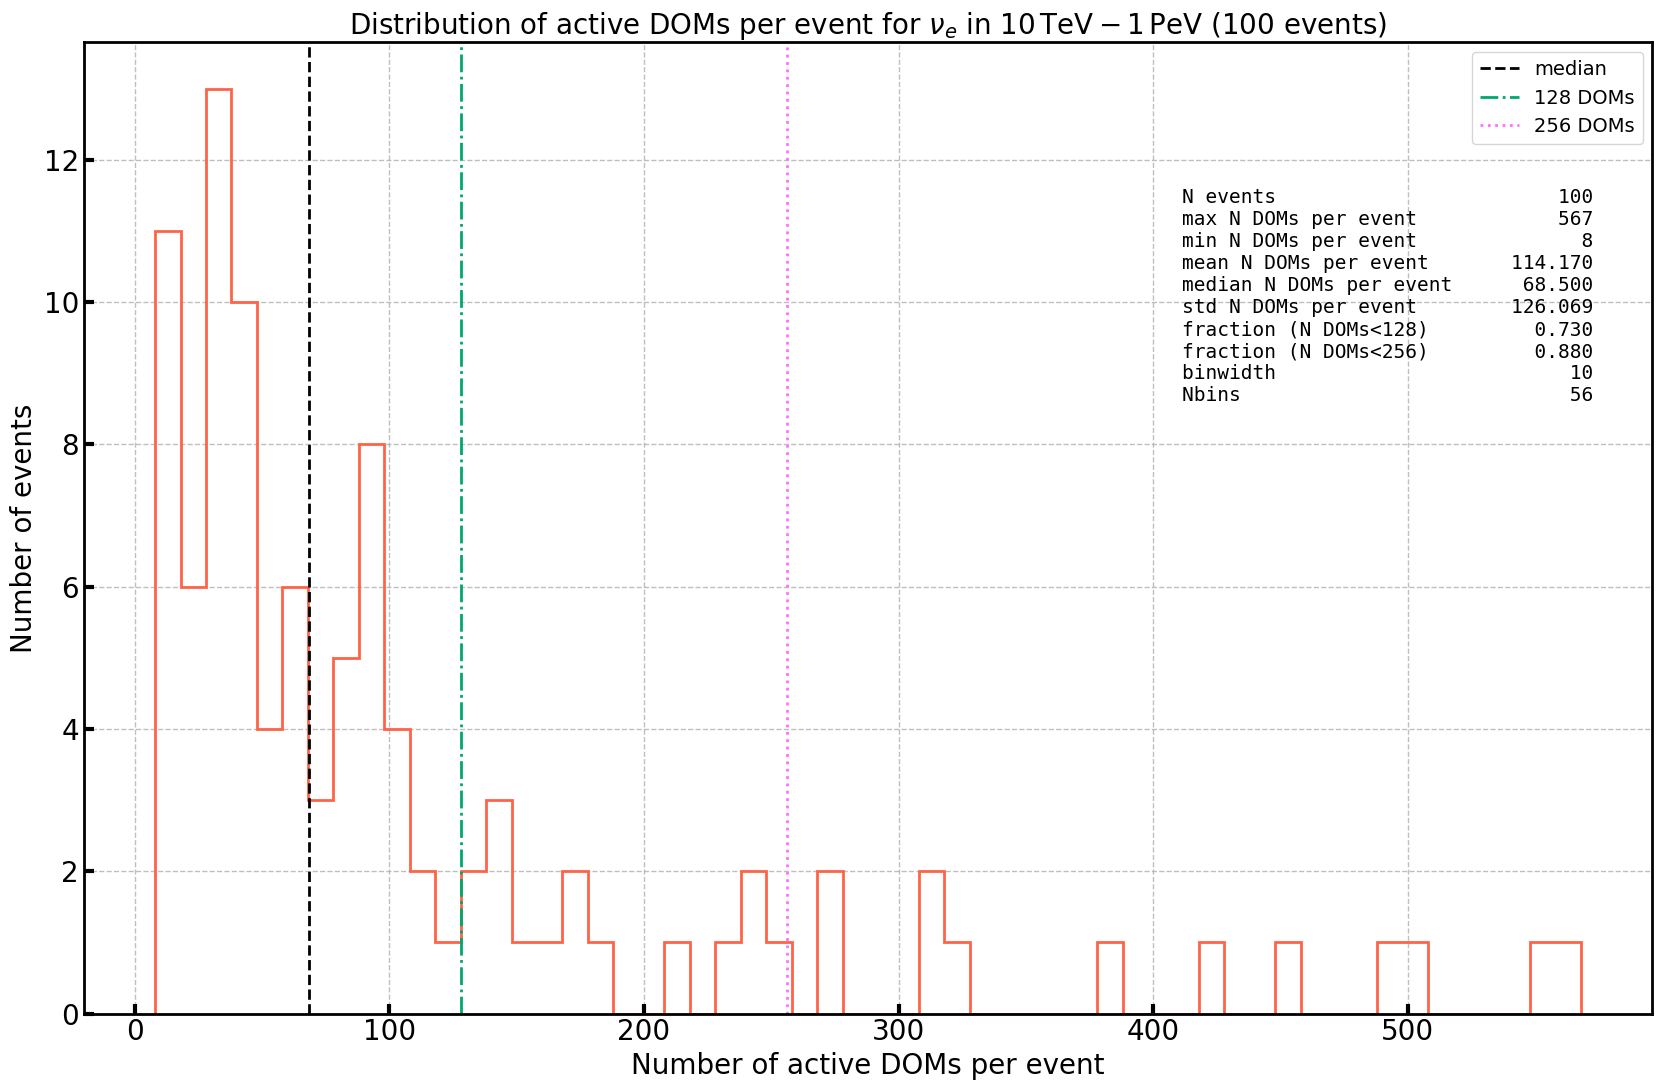

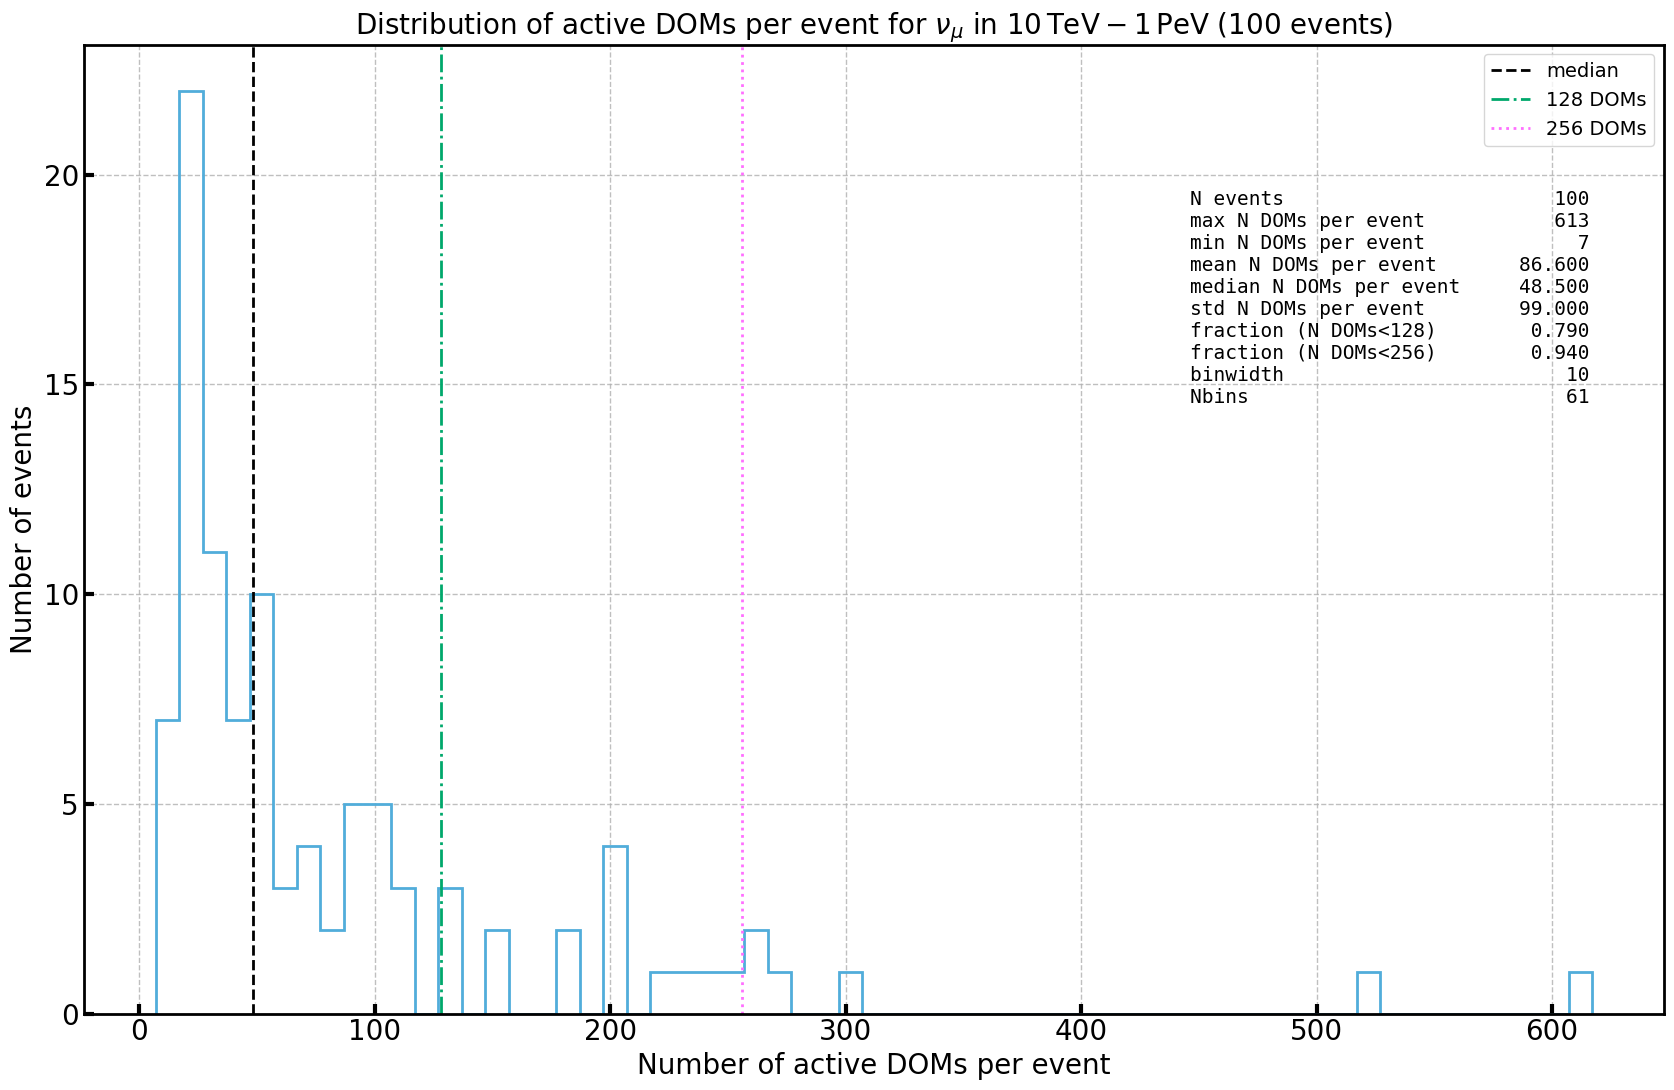

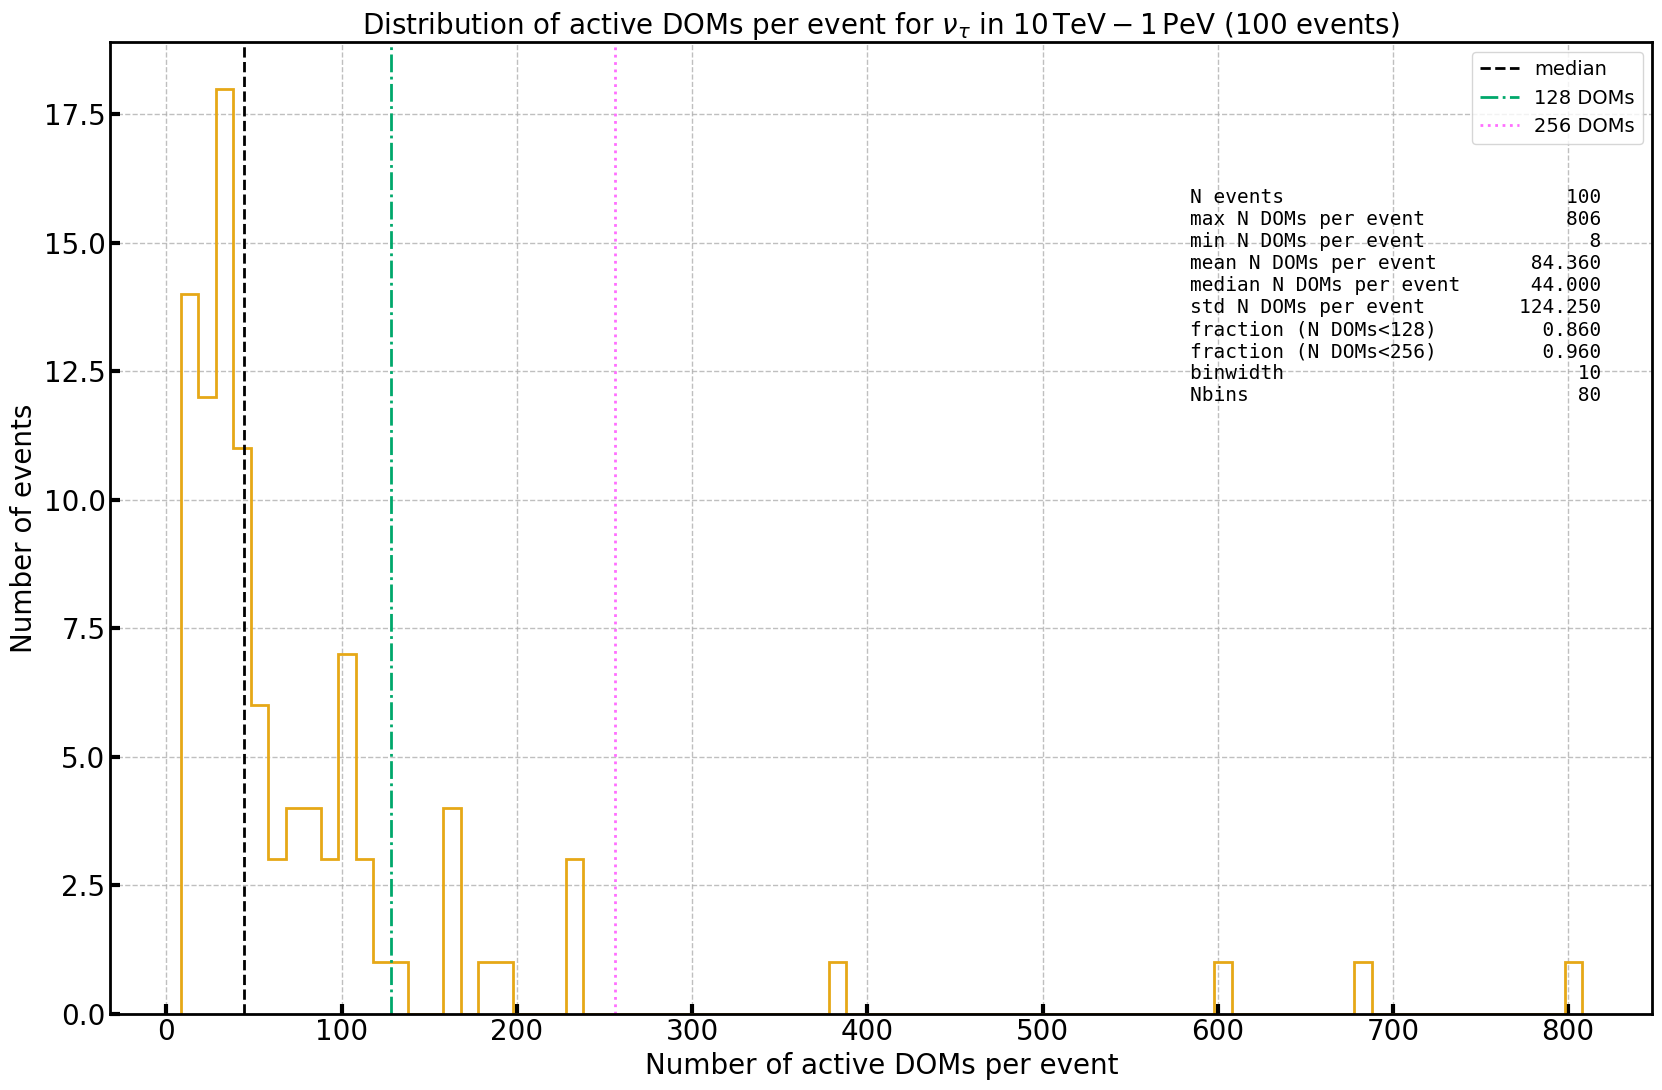

In [227]:
plot_N_DOMs_per_event(df_e_TeV, N_events=100, flavour=Flavour.E, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_N_DOMs_per_event(df_mu_TeV, N_events=100, flavour=Flavour.MU, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_N_DOMs_per_event(df_tau_TeV, N_events=100, flavour=Flavour.TAU, energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [228]:
def plot_pulse_count_distribution_single_event_per_DOM(df: pd.DataFrame,
                                               event_index: int,
                                               flavour: Flavour,
                                               energy_range: EnergyRange,
                                               min_pulses: int = 20) -> None:
    """
    Plot the distribution of number of pulses (hits) per DOM in a single event.
    Only DOMs with more than min_pulses are included.
    """
    # Choose colour
    if flavour == Flavour.E:
        colour_i = 2
    elif flavour == Flavour.MU:
        colour_i = 0
    elif flavour == Flavour.TAU:
        colour_i = 1
    else:
        raise ValueError("Flavour not recognised")

    charge_dict = get_feature_by_events(df, 'charge')
    # Get: {event_no: {(string, dom_number): [charge values]}}

    # Select the i-th event
    try:
        event_no = list(charge_dict.keys())[event_index]
        dom_charge_map = charge_dict[event_no]
    except IndexError:
        print(f"Invalid event_index: {event_index}")
        return

    # Count pulses per DOM
    pulse_counts = {
        (string, dom): len(charges)
        for (string, dom), charges in dom_charge_map.items()
        if len(charges) > min_pulses
    }

    if not pulse_counts:
        print(f"No DOMs in event {event_no} passed the minimum pulse threshold of {min_pulses}.")
        return

    counts = np.array(list(pulse_counts.values()))
    binwidth = 5
    Nbins, binwidth, bins, _, _ = getHistoParam(counts, binwidth=binwidth)

    # Plot
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(counts, bins=bins, color=getColour(colour_i), histtype='step', linewidth=2)

    ax.set_title(fr"Distribution of pulses per DOM in event {event_no} "
                 fr"(${flavour.latex}$, {energy_range.latex})", fontsize=24)
    ax.set_xlabel("Number of pulses per DOM", fontsize=16)
    ax.set_ylabel("Number of DOMs", fontsize=16)

    # Annotate
    d = {
        'Event no': event_no,
        'Total active DOMs': len(dom_charge_map),
        'DOMs plotted (>{} pulses)'.format(min_pulses): len(pulse_counts),
        'Max pulses in DOM': np.max(counts),
        'Min pulses in DOM': np.min(counts),
        'Mean pulses per DOM': np.mean(counts),
        'Median pulses per DOM': np.median(counts),
        'Std pulses per DOM': np.std(counts),
        'binwidth': binwidth,
        'Nbins': Nbins,
    }

    add_text_to_ax(0.68, 0.85, nice_string_output(d), ax, fontsize=14)

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_pulse_count_distribution_single_event(df: pd.DataFrame,
                                               event_index: int,
                                               flavour: Flavour,
                                               energy_range: EnergyRange) -> None:
    """
    Plot the distribution of pulse counts across all DOMs in a single event.
    All DOMs with at least one pulse are included.
    """
    # Select plotting colour based on flavour
    flavour_to_colour = {Flavour.MU: 0, Flavour.TAU: 1, Flavour.E: 2}
    colour_i = flavour_to_colour.get(flavour)
    if colour_i is None:
        raise ValueError("Flavour not recognised")

    charge_dict = get_feature_by_events(df, 'charge')

    try:
        event_no = list(charge_dict.keys())[event_index]
        dom_charge_map = charge_dict[event_no]
    except IndexError:
        print(f"Invalid event_index: {event_index}")
        return

    # Count pulses for all DOMs (at least one pulse per DOM is guaranteed)
    counts = np.array([len(charges) for charges in dom_charge_map.values()])

    binwidth = 5
    Nbins, binwidth, bins, _, _ = getHistoParam(counts, binwidth=binwidth)

    # Plot
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(counts, bins=bins, color=getColour(colour_i), histtype='step', linewidth=2)

    ax.set_title(fr"Distribution of pulses across DOMs in event {event_no} "
                 fr"(${flavour.latex}$, {energy_range.latex})", fontsize=24)
    ax.set_xlabel("Number of pulses per DOM", fontsize=16)
    ax.set_ylabel("Number of DOMs", fontsize=16)

    # Annotate
    d = {
        'Event no': event_no,
        'Active DOMs': len(dom_charge_map),
        'max N pulses in DOM': np.max(counts),
        'min N pulses in DOM': np.min(counts),
        'median N pulses per DOM': f"{np.median(counts):.0f}",
        'mean N pulses per DOM': np.mean(counts),
        'std N pulses per DOM': np.std(counts),
        'binwidth': binwidth,
        'Nbins': Nbins,
    }

    add_text_to_ax(0.68, 0.85, nice_string_output(d), ax, fontsize=14)

    plt.tight_layout()
    plt.show()


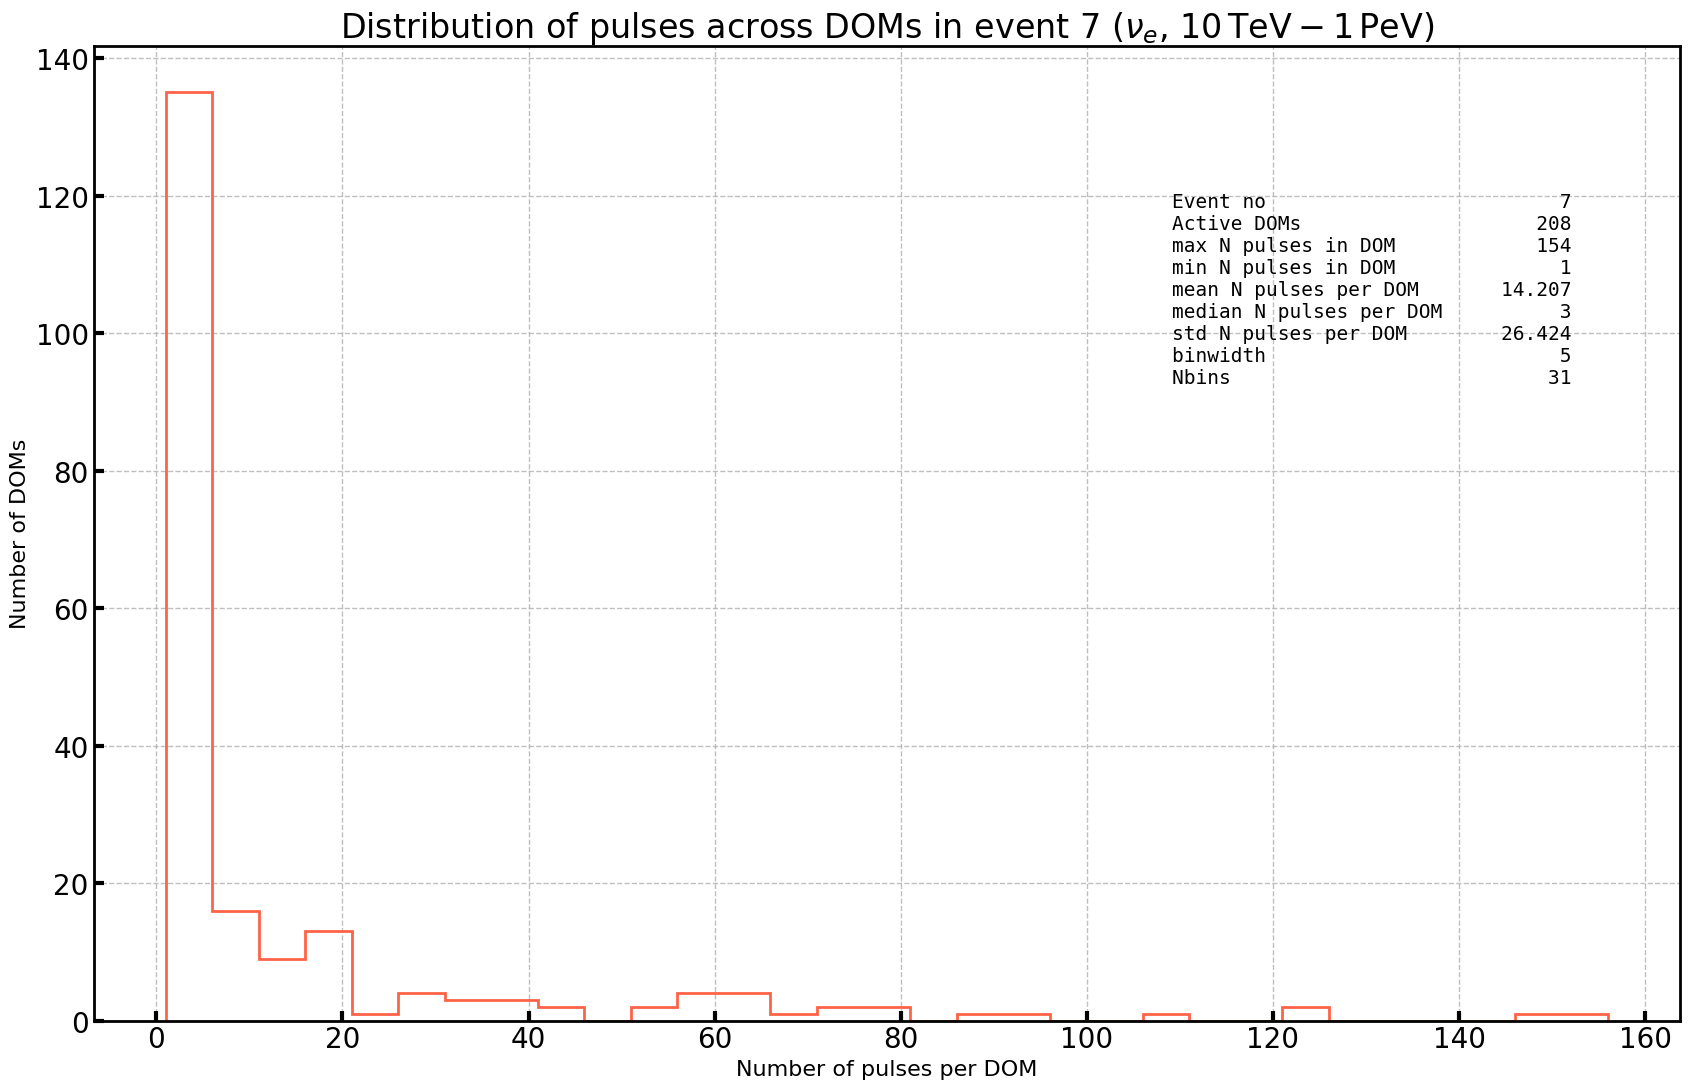

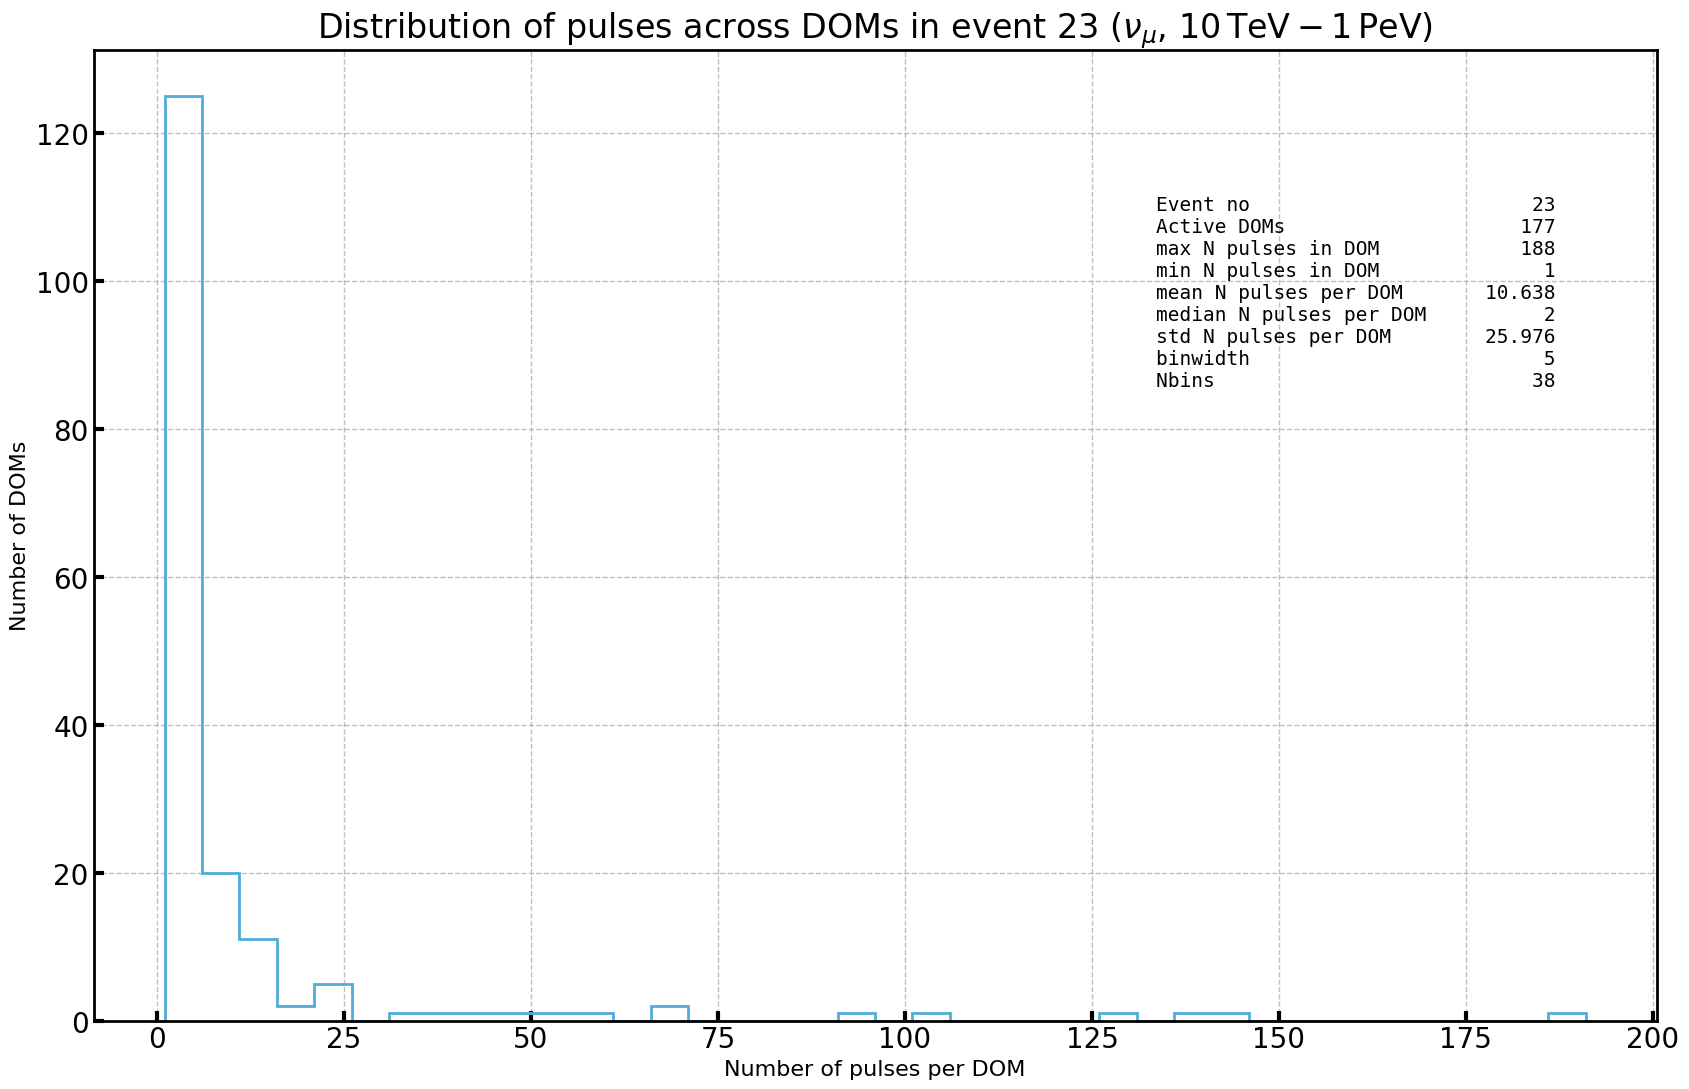

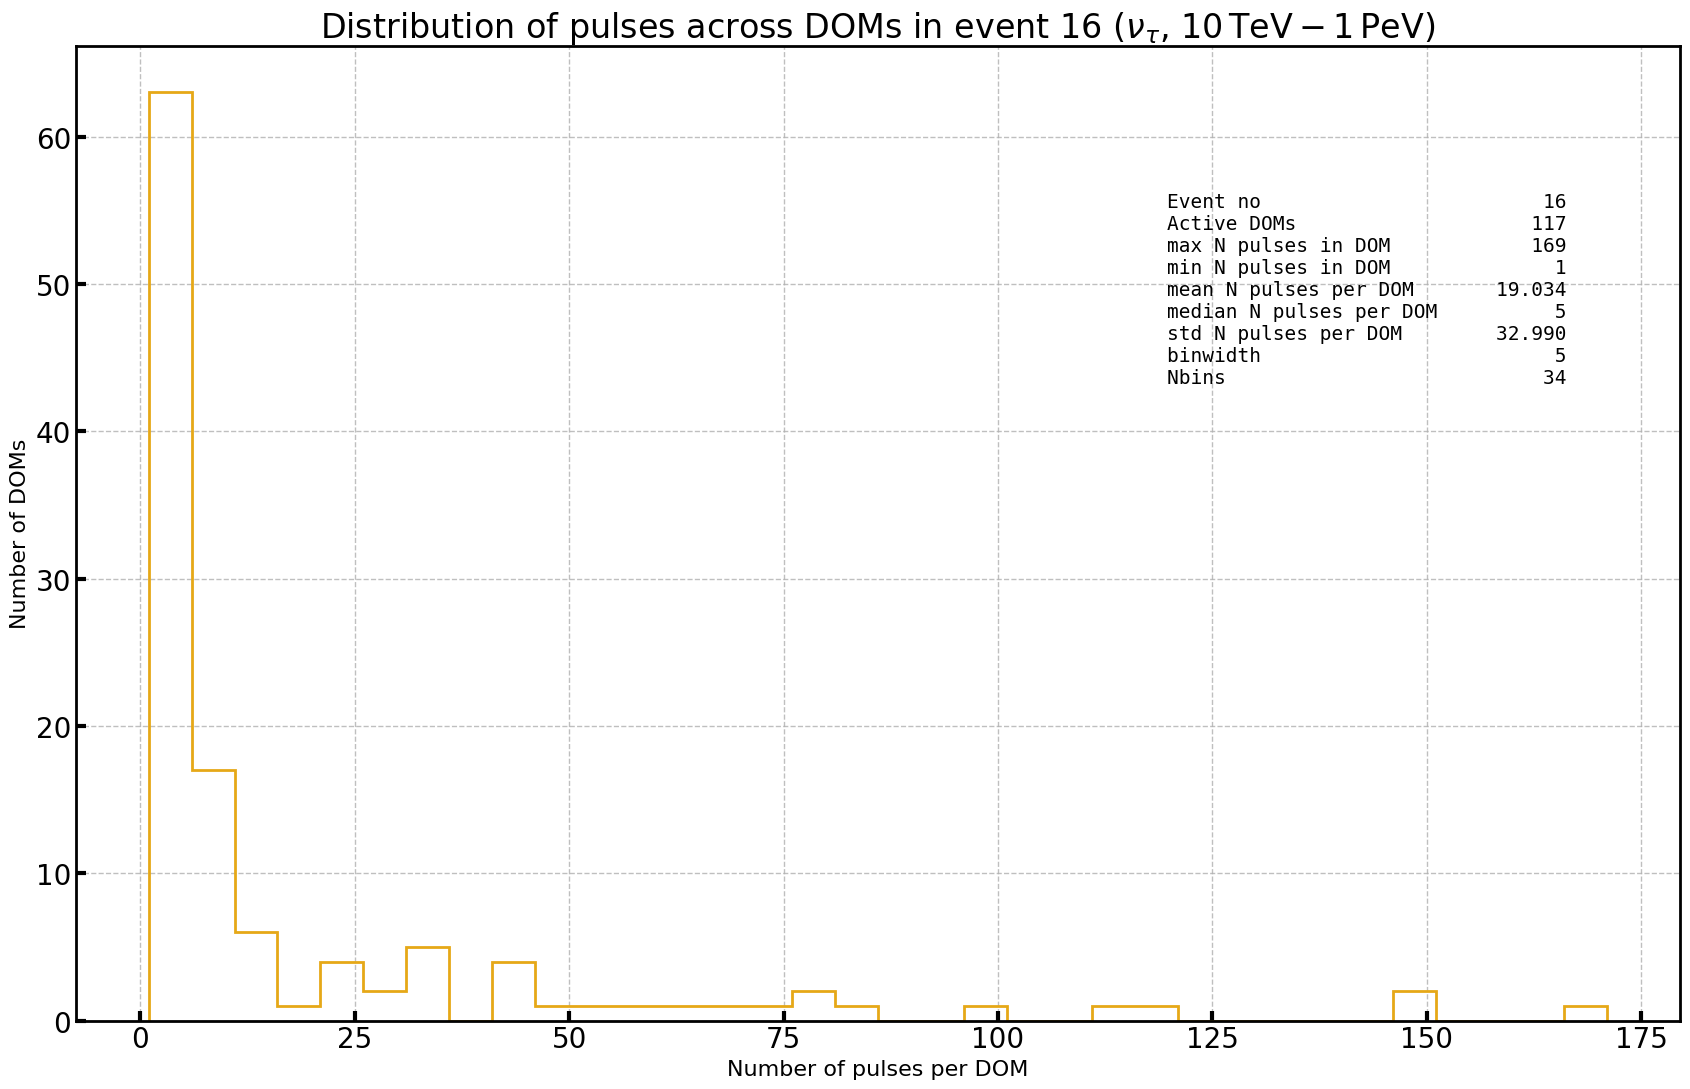

In [230]:
plot_pulse_count_distribution_single_event(df_e_TeV, event_index=7, flavour=Flavour.E, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_pulse_count_distribution_single_event(df_mu_TeV, event_index=23, flavour=Flavour.MU, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_pulse_count_distribution_single_event(df_tau_TeV, event_index=16, flavour=Flavour.TAU, energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [ ]:
def plot_pulse_count_distribution_multi_event(df: pd.DataFrame,
                                              N_events: int, 
                                              flavour: Flavour, 
                                              energy_range: EnergyRange) -> None:
    """
    Plot distribution of number of pulses per DOM across multiple events.
    All DOMs with at least one pulse are included.
    """
    charge_dict = get_feature_by_events(df, 'charge')
    
    # Select plotting colour
    flavour_to_colour = {Flavour.MU: 0, Flavour.TAU: 1, Flavour.E: 2}
    colour_i = flavour_to_colour.get(flavour)
    if colour_i is None:
        raise ValueError("Flavour not recognised")

    # Collect pulse counts
    pulse_counts = []
    for i, dom_charge_map in enumerate(charge_dict.values()):
        if i >= N_events:
            break
        for charges in dom_charge_map.values():
            pulse_counts.append(len(charges))

    if not pulse_counts:
        print(f"No active DOMs found in first {N_events} events.")
        return

    counts = np.array(pulse_counts)
    binwidth = 5
    Nbins, binwidth, bins, _, _ = getHistoParam(counts, binwidth=binwidth)

    # Plot
    fig, ax = plt.subplots(figsize=(17, 11))
    ax.hist(counts, bins=bins, color=getColour(colour_i), histtype='step', linewidth=2)

    ax.set_title(fr"Distribution of pulses across DOMs in {N_events} events "
                 fr"(${flavour.latex}$, {energy_range.latex})", fontsize=24)
    ax.set_xlabel("Number of pulses per DOM", fontsize=16)
    ax.set_ylabel("Number of DOMs", fontsize=16)

    # Annotate
    d = {
        'Total events': N_events,
        'Total active DOMs': len(counts),
        'Active DOMs per event': f"{len(counts) / N_events:.2f}",
        'max N pulses in DOM': np.max(counts),
        'min N pulses in DOM': np.min(counts),
        'median N pulses per DOM': f"{np.median(counts):.0f}",
        'mean N pulses per DOM': np.mean(counts),
        'std N pulses per DOM': np.std(counts),
        'binwidth': binwidth,
        'Nbins': Nbins,
    }

    add_text_to_ax(0.68, 0.85, nice_string_output(d), ax, fontsize=14)

    plt.tight_layout()
    plt.show()


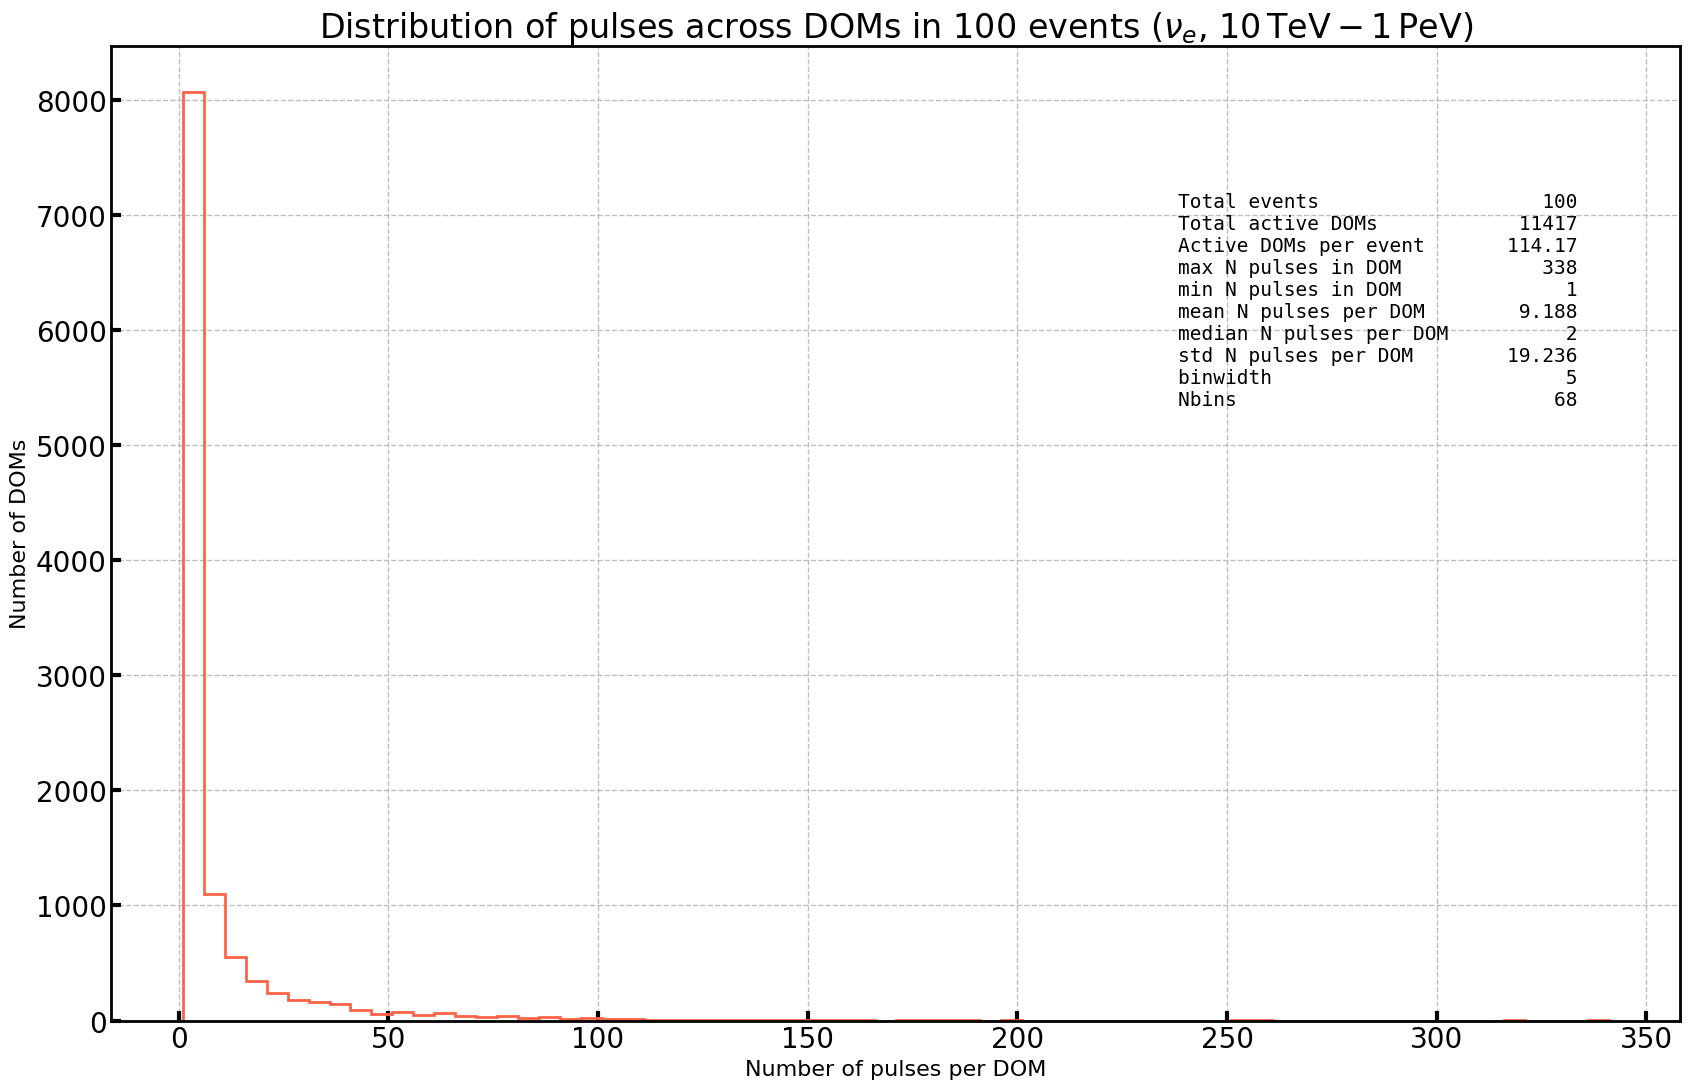

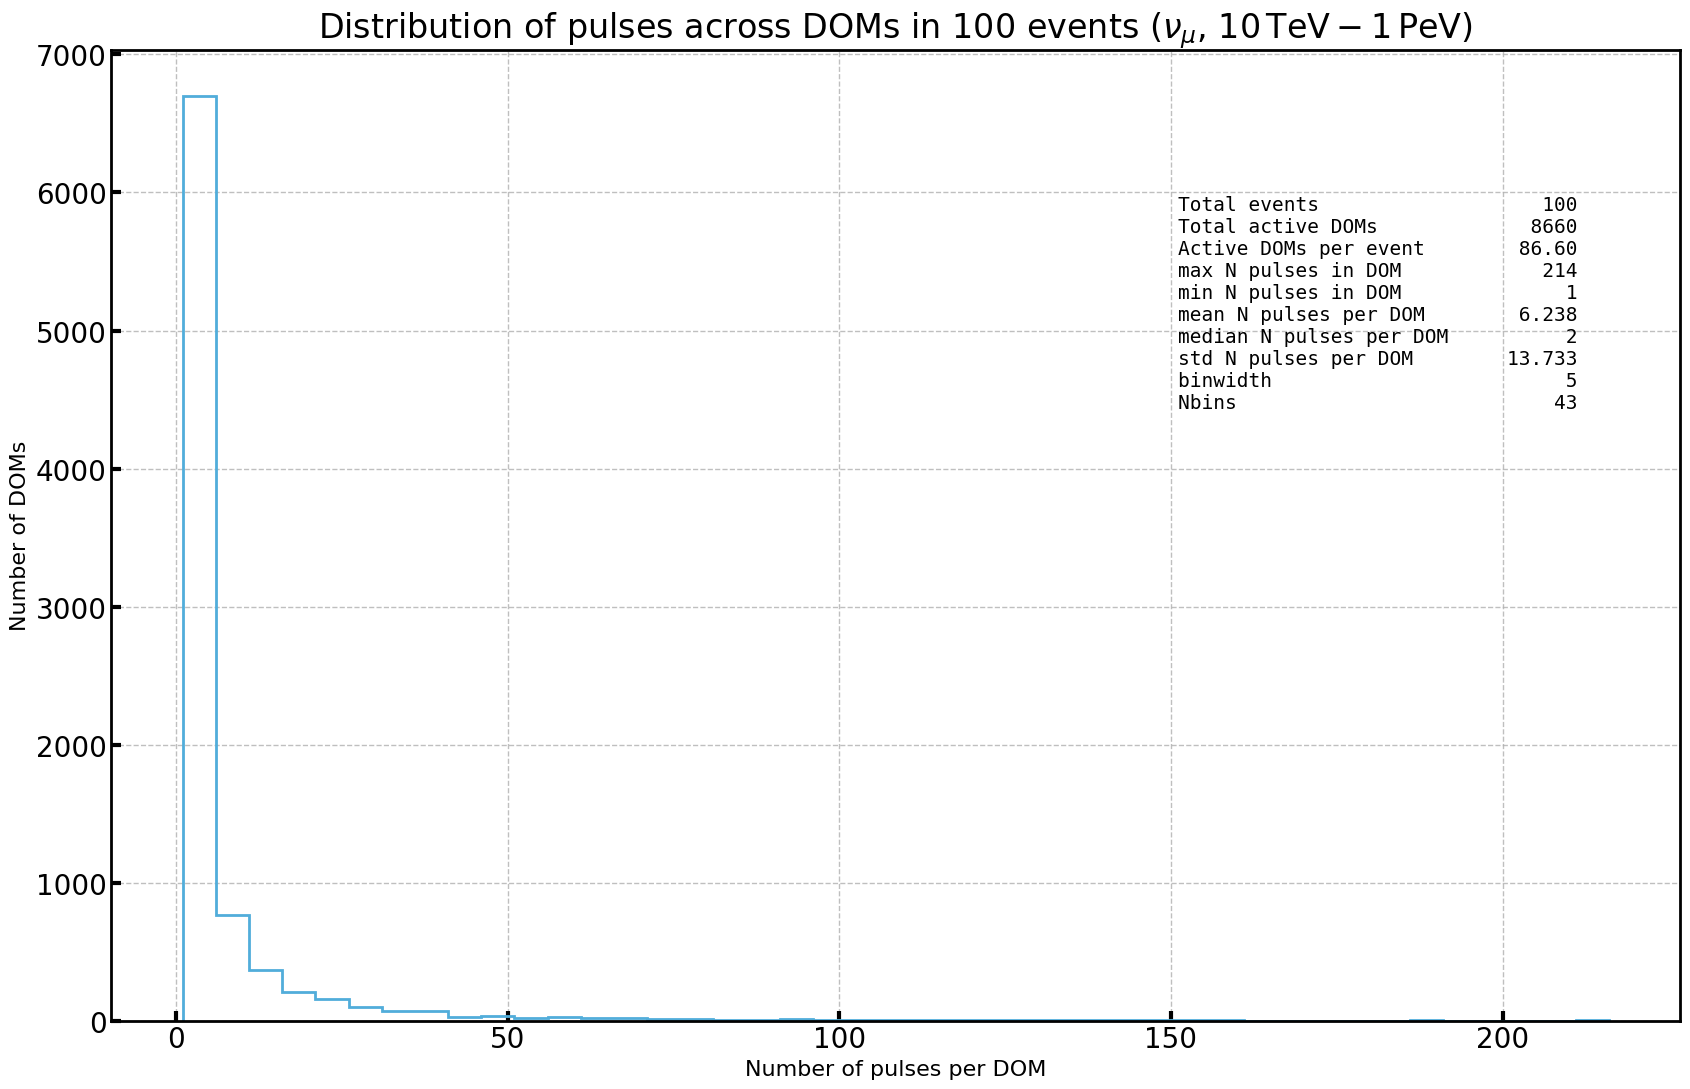

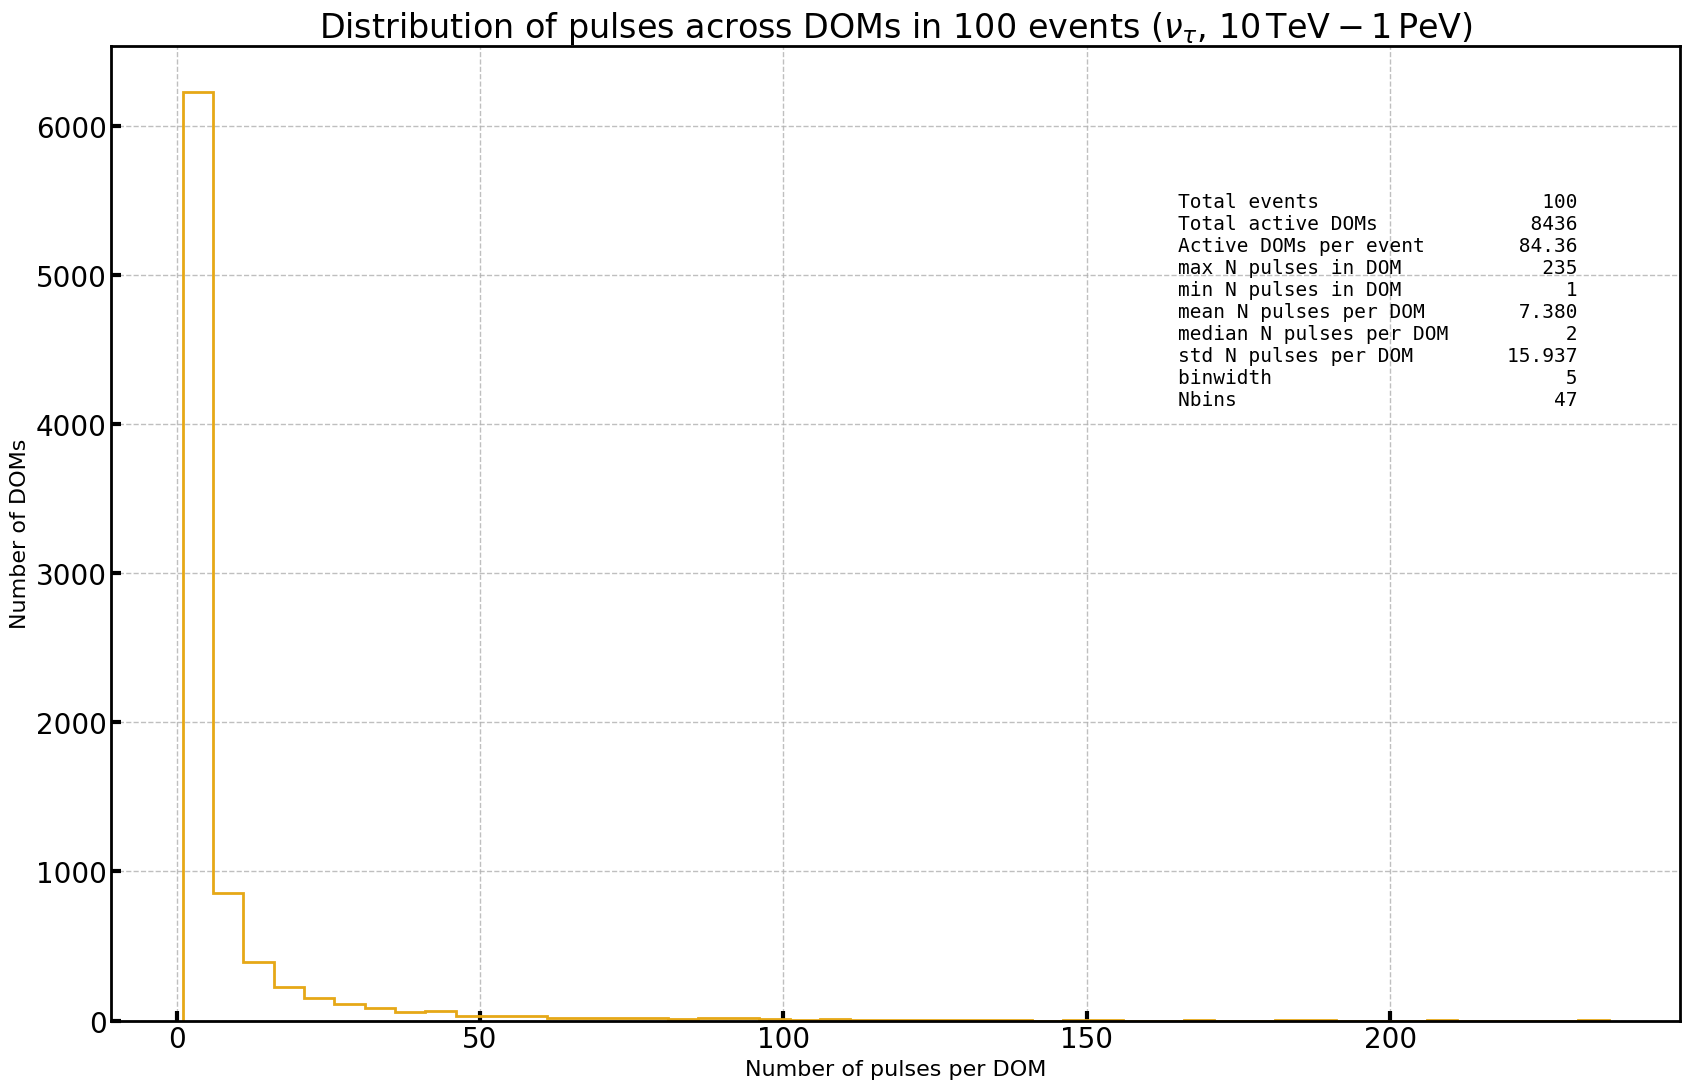

In [232]:
plot_pulse_count_distribution_multi_event(df_e_TeV, N_events=100, flavour=Flavour.E, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_pulse_count_distribution_multi_event(df_mu_TeV, N_events=100, flavour=Flavour.MU, energy_range=EnergyRange.ER_10_TEV_1_PEV)
plot_pulse_count_distribution_multi_event(df_tau_TeV, N_events=100, flavour=Flavour.TAU, energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [233]:
def plot_DOM_activation_multi_event(df: pd.DataFrame,
                        N_events: int, 
                        flavour: Flavour, 
                        energy_range: EnergyRange) -> None:
    """
    Visualise DOM activation over N events as a heatmap.
    Y-axis: dom_number (1 at top), X-axis: string (1 to 86)
    Colour: Number of charge entries (activation intensity)
    """
    # Get: {event_no: {(string, dom_number): [charge values]}}
    charge_dict = get_feature_by_events(df, 'charge')

    # Aggregate counts across N_events
    activation = {}  # {(string, dom_number): total_count}
    for i, event_data in enumerate(charge_dict.values()):
        if i >= N_events:
            break
        for (string, dom), charges in event_data.items():
            activation[(string, dom)] = activation.get((string, dom), 0) + len(charges)

    # Initialise grid: 60 rows (DOMs), 86 cols (strings)
    grid = np.zeros((60, 86), dtype=int)
    for (string, dom), count in activation.items():
        s = int(string)
        d = int(dom)
        if 1 <= s <= 86 and 1 <= d <= 60:
            grid[60 - d, s - 1] = count


    # Plot heatmap
    fig, ax = plt.subplots(figsize=(24, 18))
    im = ax.imshow(grid, cmap='YlGnBu', aspect='auto')

    ax.set_title(fr"DOM Activation Heatmap over {N_events} events of ${flavour.latex}$ in {energy_range.latex}")
    ax.set_xlabel("String Number")
    ax.set_ylabel("DOM Number")
    ax.set_xticks(np.arange(0, 86, 5))
    ax.set_yticks(np.arange(0, 60, 5))
    ax.set_yticklabels([str(i) for i in range(60, 0, -5)])
    ax.invert_yaxis()

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(f"Cummulative numbers of pulses of {N_events} events")

    plt.tight_layout()
    plt.show()


In [234]:
# plot_DOM_activation_multi_event(df_e_TeV, N_events=1, flavour=Flavour.E, energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [235]:
# plot_DOM_activation_multi_event(df_mu_TeV, N_events=1, flavour=Flavour.MU, energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [236]:
def plot_DOM_activation_individual_event(df: pd.DataFrame,
                                         N_events: int, 
                                         flavour: Flavour, 
                                         energy_range: EnergyRange) -> None:
    """
    Plot individual DOM activation maps for the first N events.
    """
    charge_dict = get_feature_by_events(df, 'charge')
    # {event_no: {(string, dom_number): [charge values]}}

    for i, (event_no, dom_data) in enumerate(charge_dict.items()):
        if i >= N_events:
            break
        
        grid = np.zeros((60, 86), dtype=int)
        for (string, dom), charges in dom_data.items():
            s = int(string)
            d = int(dom)
            if 1 <= s <= 86 and 1 <= d <= 60:
                grid[60 - d, s - 1] = len(charges)

        # Plot heatmap
        fig, ax = plt.subplots(figsize=(24, 18))
        im = ax.imshow(grid, cmap='YlGnBu', aspect='auto')

        ax.set_title(fr"DOM Activation Heatmap for event {event_no} of ${flavour.latex}$ in {energy_range.latex}")
        ax.set_xlabel("String Number")
        ax.set_ylabel("DOM Number")
        ax.set_xticks(np.arange(0, 86, 5))
        ax.set_yticks(np.arange(0, 60, 5))
        ax.set_yticklabels([str(i) for i in range(60, 0, -5)])
        ax.invert_yaxis()

        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Number of Pulses (Charge Hits)")

        plt.tight_layout()
        plt.show()


In [237]:
# plot_DOM_activation_individual_event(df_e_TeV, 
#                                      N_events=1, 
#                                      flavour=Flavour.E, 
#                                      energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [238]:
# plot_DOM_activation_individual_event(df_mu_TeV, 
#                                      N_events=1, 
#                                      flavour=Flavour.MU, 
#                                      energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [247]:
def get_elapsed_time_until_charge_fraction(charge_list, time_list, p1=10, p2=50):
    _fillIncomplete = -1.0
    if len(charge_list) < 2:
        return _fillIncomplete, _fillIncomplete

    # Sort by time
    sorted_indices = np.argsort(time_list)
    charges = np.array(charge_list)[sorted_indices]
    times = np.array(time_list)[sorted_indices]

    Qtotal = np.sum(charges)
    cumulated = np.cumsum(charges)

    idx1 = np.searchsorted(cumulated, p1 / 100 * Qtotal, side="right")
    idx2 = np.searchsorted(cumulated, p2 / 100 * Qtotal, side="right")

    T1 = times[idx1] - times[0] if idx1 < len(times) else _fillIncomplete
    T2 = times[idx2] - times[0] if idx2 < len(times) else _fillIncomplete

    return T1, T2


def get_accumulated_charge_after_ns(charge_list, time_list, ns1=25, ns2=75):
    _fillIncomplete = -1.0
    if len(charge_list) < 1:
        return _fillIncomplete, _fillIncomplete, _fillIncomplete

    t0 = time_list[0]
    time_offsets = np.array(time_list) - t0
    charges = np.array(charge_list)

    Q1 = np.sum(charges[time_offsets < ns1])
    Q2 = np.sum(charges[time_offsets < ns2])
    Qtotal = np.sum(charges)

    return Q1, Q2, Qtotal


In [270]:
def plot_charge_time_single_event_by_DOM(df: pd.DataFrame,
                                         event_index: int, 
                                         flavour: Flavour, 
                                         energy_range: EnergyRange,
                                         N_pulses_cut: int = 150) -> None:
    """
    Visualise charge vs time scatter plots for all DOMs in a selected event.
    Each figure shows one DOM's hits.
    """
    # Assign colour based on flavour
    if flavour == Flavour.E:
        colour_i = 2
    elif flavour == Flavour.MU:
        colour_i = 0
    elif flavour == Flavour.TAU:
        colour_i = 1
    else:
        raise ValueError("Flavour not recognised")

    # Get grouped data
    charge_dict = get_feature_by_events(df, 'charge')
    time_dict = get_feature_by_events(df, 'dom_time')
    # {event_no: {(string, dom_number): [values]}}
    
    # Select the i-th event
    try:
        event_no = list(charge_dict.keys())[event_index]
        charge_map = charge_dict[event_no]
        time_map = time_dict[event_no]
    except IndexError:
        print(f"Invalid event_index: {event_index}")
        return

    # Plot per DOM
    print(f" {len(charge_map)} active DOMs in event {event_no}")
    for (string, dom) in charge_map:
        charge_list = charge_map[(string, dom)]
        time_list = time_map.get((string, dom), [])
        if len(charge_list) != len(time_list):
            continue
        if len(charge_list) > N_pulses_cut:
            fig, ax = plt.subplots(figsize=(14, 9))
            colour = getColour(colour_i)
            ax.vlines(time_list, 0, charge_list, color=colour, linewidth=2,zorder=1)
            ax.scatter(time_list, charge_list, s=30, color=colour, edgecolor='black', linewidth=1, zorder=2)

            ax.set_title(fr"Charge vs Arrivel Time for (string{string:.0f}, DOM{dom:.0f}) in event {event_no} of ${flavour.latex}$ in {energy_range.latex}")
            ax.set_xlabel("Arrival time (ns)")
            ax.set_ylabel("Charge")
            d = {
                'N pulses': len(charge_list),
                'max charge': max(charge_list),
                'min charge': min(charge_list),
                'median charge': np.median(charge_list),
                'mean charge': np.mean(charge_list),
                'max time': f"{max(time_list):.0f}",
                'min time': f"{min(time_list):.0f}",
                'median time': f"{np.median(time_list):.0f}",
                'mean time': np.mean(time_list),
            }
            d_first ={
                '(t1,q1)' : f"({time_list[0]:.0f}, {charge_list[0]:.3f})",
                '(t2,q2)' : f"({time_list[1]:.0f}, {charge_list[1]:.3f})",
                '(t3,q3)' : f"({time_list[2]:.0f}, {charge_list[2]:.3f})",
                '(t4,q4)' : f"({time_list[3]:.0f}, {charge_list[3]:.3f})",
                '(t5,q5)' : f"({time_list[4]:.0f}, {charge_list[4]:.3f})",
            }
            T10, T50 = get_elapsed_time_until_charge_fraction(charge_list, time_list)
            Q25, Q75, Qtotal = get_accumulated_charge_after_ns(charge_list, time_list)
            d_quantiles = {
                r'$T_{10\%}$':f"{T10:.0f}",
                r'$T_{50\%}$':f"{T50:.0f}",
                r'$\sigma_T $  ':f"{np.std(time_list):.3f}",
                r"$Q_{0-25ns}$":f"{Q25:.3f}",
                r"$Q_{0-75ns}$":f"{Q75:.3f}",
                r"$Q_{\infty}$" :f"{Qtotal:.3f}",
                }
            add_text_to_ax(0.60, 0.95, nice_string_output(d), ax, fontsize=14)
            add_text_to_ax(0.50, 0.65, nice_string_output(d_first), ax, fontsize=14)
            add_text_to_ax(0.80, 0.65, nice_string_output(d_quantiles), ax, fontsize=14)
            plt.tight_layout()
            plt.show()


 208 active DOMs in event 7


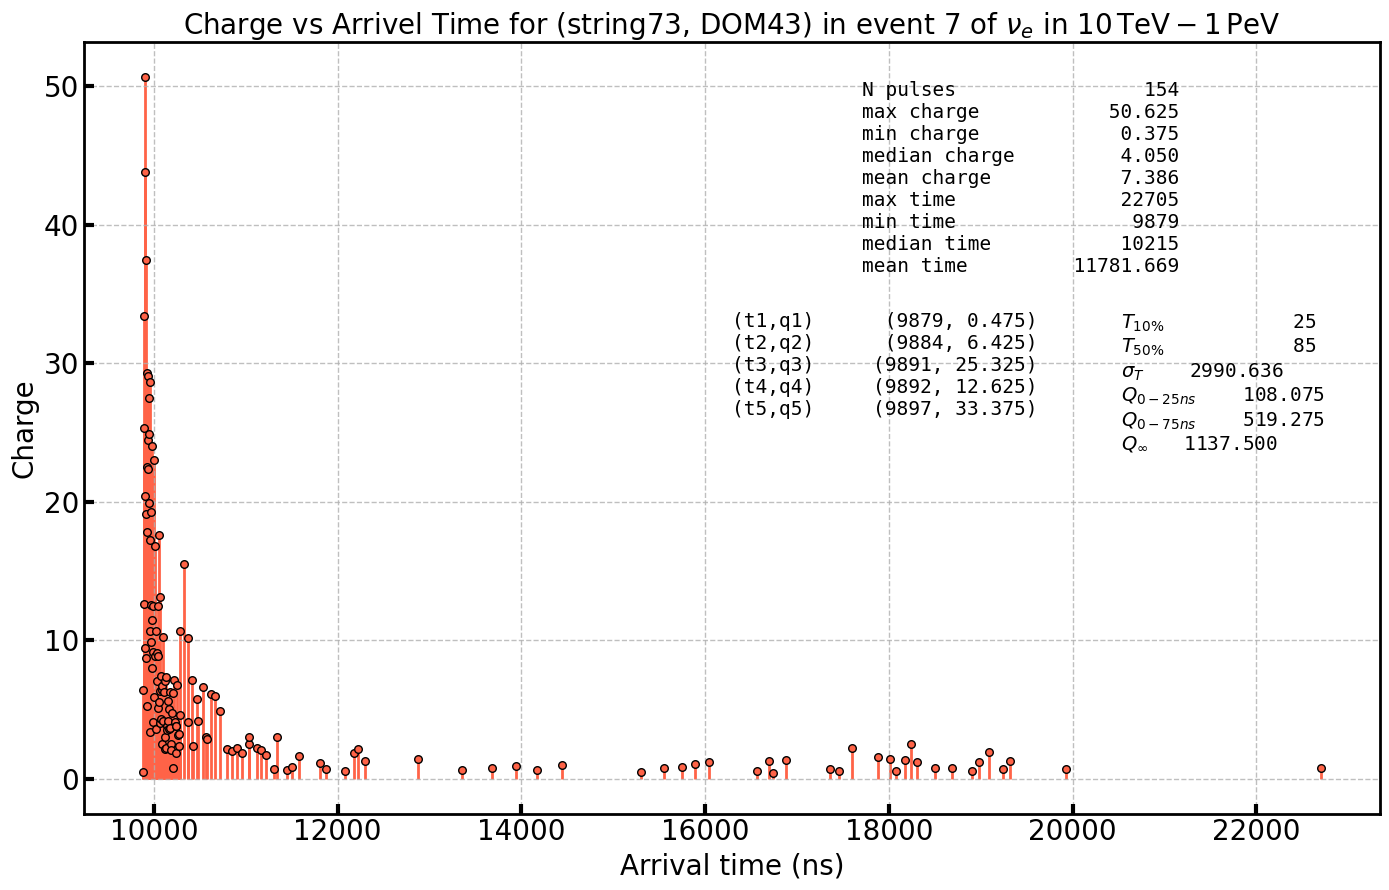

In [271]:
plot_charge_time_single_event_by_DOM(df_e_TeV,
                                  event_index=7, 
                                  flavour=Flavour.E, 
                                  energy_range=EnergyRange.ER_10_TEV_1_PEV)

 177 active DOMs in event 23


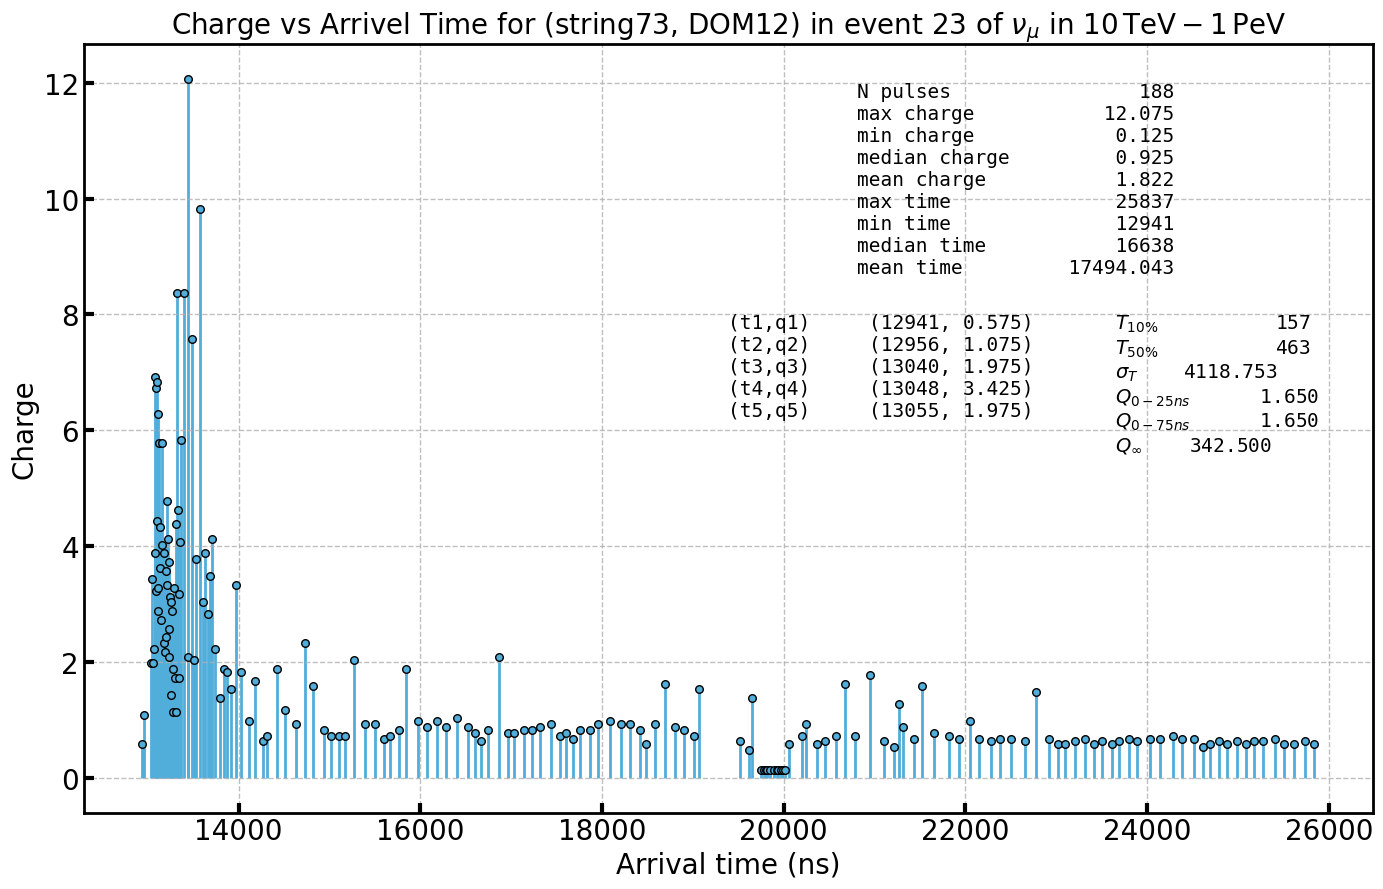

In [272]:
plot_charge_time_single_event_by_DOM(df_mu_TeV,
                                  event_index=23, # 16
                                  flavour=Flavour.MU, 
                                  energy_range=EnergyRange.ER_10_TEV_1_PEV)

 117 active DOMs in event 16


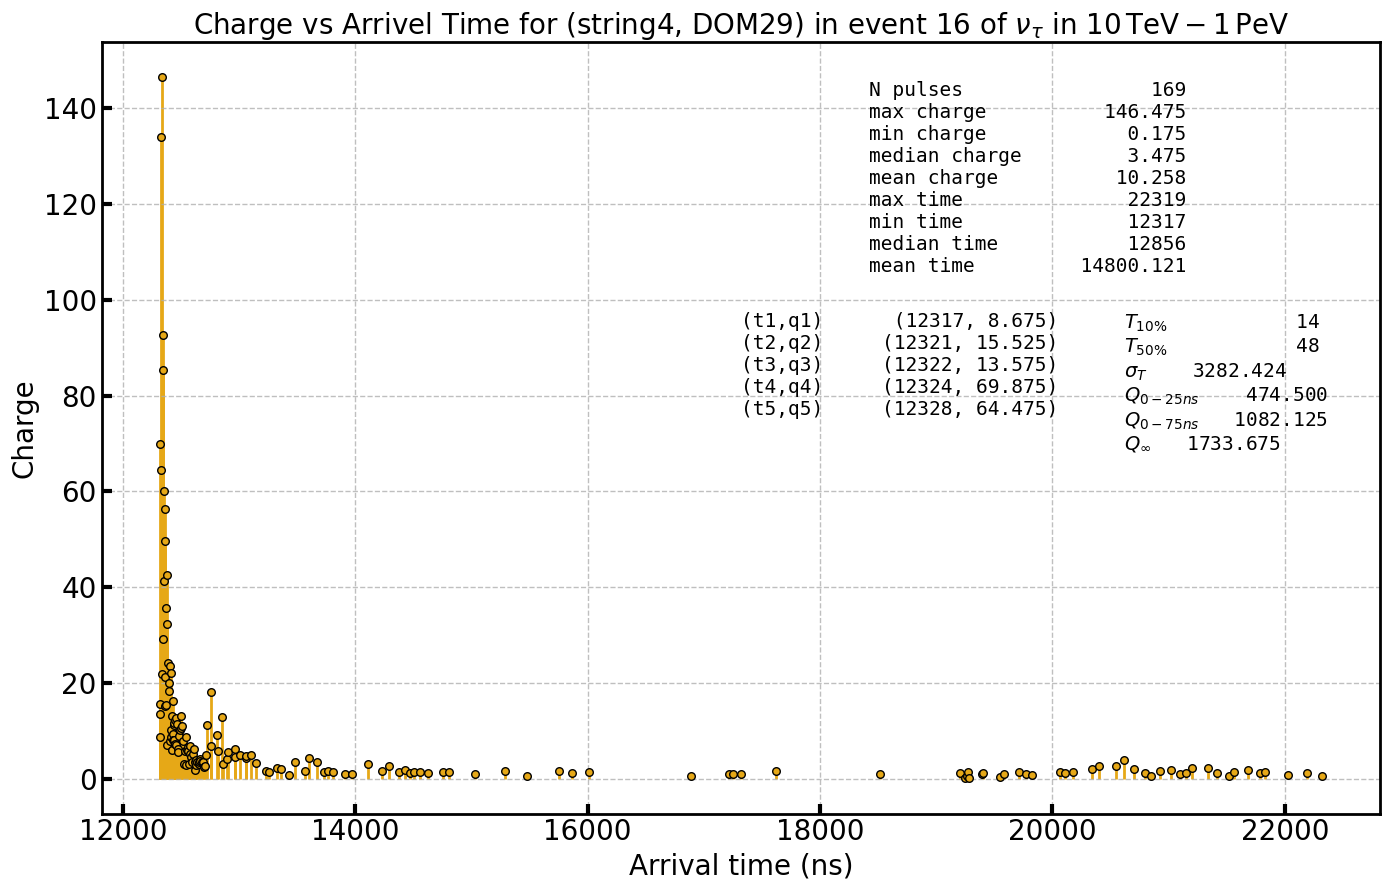

In [273]:
plot_charge_time_single_event_by_DOM(df_tau_TeV,
                                  event_index=16, #10
                                  flavour=Flavour.TAU, 
                                  energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [ ]:
def plot_multi_event_distribution(df: pd.DataFrame, 
                                  feature:str, 
                                  N_events: int, 
                                  binwidth : float,
                                  flavour: Flavour, energy_range: EnergyRange):
    if flavour == Flavour.E:
        colour_i = 2
    elif flavour == Flavour.MU:
        colour_i = 0
    elif flavour == Flavour.TAU:
        colour_i = 1
    else:
        raise ValueError("Flavour not recognised")
    
    data_dict = get_feature_by_events(df, feature)
    # {event_no: {(string, dom_number): [values]}}
    collected_data = []
    
    for i, dom_pulse_map in enumerate(data_dict.values()):
        if i >= N_events:
            break
        collected_data.extend(dom_pulse_map.values())
        # for pulse in dom_pulse_map.values():
            collected_data.append(len(pulse))
    #     collected_data.extend(data_item)
    # collected_data = np.array(collected_data)
    # Nbins, binwidth, bins, counts, bin_centers = getHistoParam(collected_data, binwidth=binwidth)
    # # avg_counts = counts / N_events
    # fig, ax = plt.subplots(figsize=(17, 11))
    # # ax.hist(avg_counts, bins=bins, color=getColour(0), linewidth=2, histtype ='step')
    # ax.hist(collected_data, bins=bins, color=getColour(colour_i), linewidth=2, histtype ='step')
    # ax.set_title(fr"Distribution of {feature} for {N_events} events of ${flavour.latex}$ in {energy_range.latex}")
    # ax.set_xlabel(f"{feature}")
    # ax.set_ylabel(f'Counts/{N_events}')
    # d = {
    #     'N pulses' : len(collected_data),
    #     'avg N pulses per event' : len(collected_data) / N_events,
    #     'max' : np.max(collected_data),
    #     'min' : np.min(collected_data),
    #     'mean' : np.mean(collected_data),
    #     'median' : np.median(collected_data),
    # }
    # add_text_to_ax(0.65, 0.75, nice_string_output(d), ax, fontsize=14)
    

In [ ]:
# plot_multi_event_distribution(df_e_TeV, 
#                               feature = 'charge', 
#                               N_events=100, 
#                               binwidth=0.1,
#                               flavour=Flavour.E, 
#                               energy_range=EnergyRange.ER_10_TEV_1_PEV)

Event 0: 92
Event 1: 98
Event 2: 44
Event 3: 40
Event 4: 14
Event 5: 323
Event 6: 62
Event 7: 208
Event 8: 33
Event 9: 89
Event 10: 499
Event 11: 42
Event 12: 19
Event 13: 241
Event 14: 46
Event 15: 91
Event 16: 242
Event 17: 90
Event 18: 85
Event 19: 17
Event 20: 140
Event 21: 83
Event 22: 37
Event 23: 60
Event 24: 30
Event 25: 93
Event 26: 496
Event 27: 92
Event 28: 46
Event 29: 383
Event 30: 23
Event 31: 58
Event 32: 567
Event 33: 37
Event 34: 49
Event 35: 41
Event 36: 14
Event 37: 78
Event 38: 78
Event 39: 48
Event 40: 66
Event 41: 32
Event 42: 56
Event 43: 30
Event 44: 66
Event 45: 59
Event 46: 71
Event 47: 44
Event 48: 44
Event 49: 48
Event 50: 26
Event 51: 8
Event 52: 93
Event 53: 184
Event 54: 78
Event 55: 46
Event 56: 28
Event 57: 99
Event 58: 109
Event 59: 37
Event 60: 166
Event 61: 108
Event 62: 143
Event 63: 127
Event 64: 12
Event 65: 77
Event 66: 23
Event 67: 315
Event 68: 36
Event 69: 15
Event 70: 275
Event 71: 13
Event 72: 44
Event 73: 315
Event 74: 13
Event 75: 273
Even

In [ ]:
# plot_multi_event_distribution(df_mu_TeV, 
#                               feature = 'charge', 
#                               N_events=100, 
#                               binwidth=0.1,
#                               flavour=Flavour.MU,
#                               energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [ ]:
# plot_multi_event_distribution(df_tau_TeV,
#                                 feature = 'charge', 
#                                 N_events=100, 
#                                 binwidth=0.1,
#                                 flavour=Flavour.TAU,
#                                 energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [ ]:
def plot_individual_event_distribution(df: pd.DataFrame, 
                                       feature:str, 
                                       N_events: int, 
                                       binwidth : float,
                                       flavour: Flavour, energy_range: EnergyRange):
    if flavour == Flavour.E:
        colour_i = 2
    elif flavour == Flavour.MU:
        colour_i = 0
    elif flavour == Flavour.TAU:
        colour_i = 1
    else:
        raise ValueError("Flavour not recognised")
    
    data_dict = get_feature_by_events(df, feature)
    for i, data_item in enumerate(data_dict.values()):
        if i >= N_events:
            break
        Nbins, binwidth, bins, counts, bin_centers = getHistoParam(data_item, binwidth=binwidth)
        fig, ax = plt.subplots(figsize=(17, 11))
        ax.hist(data_item, bins=bins, color=getColour(colour_i), linewidth=2, histtype ='step')
        ax.set_title(fr"Distribution of {feature} for event {i} of ${flavour.latex}$ in {energy_range.latex}")
        ax.set_xlabel(f"{feature}")
        ax.set_ylabel('Count')
        d = {
            'N pulses' : len(data_item),
            'max' : np.max(data_item),
            'min' : np.min(data_item),
            'mean' : np.mean(data_item),
            'median' : np.median(data_item),
        }
        add_text_to_ax(0.65, 0.75, nice_string_output(d), ax, fontsize=14)

In [ ]:
plot_individual_event_distribution(df_e_TeV,
                                      feature = 'charge', 
                                      N_events=15, 
                                      binwidth=0.1,
                                      flavour=Flavour.E, 
                                      energy_range=EnergyRange.ER_10_TEV_1_PEV)

TypeError: float() argument must be a string or a number, not 'dict'

In [ ]:
# plot_individual_event_distribution(df_mu_TeV,
#                                       feature = 'charge', 
#                                       N_events=15, 
#                                       binwidth=0.1,
#                                       flavour=Flavour.MU, 
#                                       energy_range=EnergyRange.ER_10_TEV_1_PEV)

In [ ]:
# plot_individual_event_distribution(df_tau_TeV,
#                                         feature = 'charge', 
#                                         N_events=15, 
#                                         binwidth=0.1,
#                                         flavour=Flavour.TAU, 
#                                         energy_range=EnergyRange.ER_10_TEV_1_PEV)